In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      kernel_initializer='he_uniform', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4316 - acc: 0.3349
Epoch 00001: val_loss improved from inf to 1.85335, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_3_conv_checkpoint/001-1.8534.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 2.4313 - acc: 0.3349 - val_loss: 1.8534 - val_acc: 0.4267
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6122 - acc: 0.5174
Epoch 00002: val_loss improved from 1.85335 to 1.53331, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_3_conv_checkpoint/002-1.5333.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.6123 - acc: 0.5174 - val_loss: 1.5333 - val_acc: 0.5586
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3209 - acc: 0.5933
Epoch 00003: val_loss did not improve from 1.53331
3680

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1435 - acc: 0.9543
Epoch 00029: val_loss did not improve from 1.39844
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1436 - acc: 0.9543 - val_loss: 1.8894 - val_acc: 0.6450
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1480 - acc: 0.9547
Epoch 00030: val_loss did not improve from 1.39844
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1480 - acc: 0.9547 - val_loss: 2.1237 - val_acc: 0.6171
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1393 - acc: 0.9572
Epoch 00031: val_loss did not improve from 1.39844
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1394 - acc: 0.9572 - val_loss: 1.9258 - val_acc: 0.6341
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1334 - acc: 0.9593
Epoch 00032: val_loss did not improve from 1.39844
36805/36805 [===========

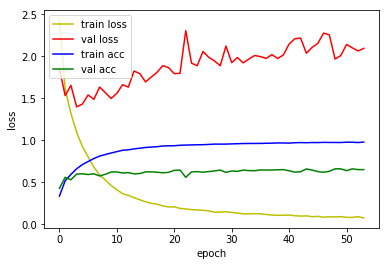

4815/4815 [==============================] - 4s 830us/sample - loss: 1.5318 - acc: 0.5458
Loss: 1.531757095991513 Accuracy: 0.54579437

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3003 - acc: 0.3340
Epoch 00001: val_loss improved from inf to 1.46679, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_4_conv_checkpoint/001-1.4668.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 2.3001 - acc: 0.3341 - val_loss: 1.4668 - val_acc: 0.5532
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5234 - acc: 0.5323
Epoch 00002: val_loss improved from 1.46679 to 1.21550, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_4_conv_checkpoint/002-1.2155.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.5234 - acc: 0.5323 - val_loss: 1.2155 - val_acc: 0.6224
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2534 - acc: 0.9173
Epoch 00027: val_loss did not improve from 0.91028
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2534 - acc: 0.9173 - val_loss: 1.0605 - val_acc: 0.7424
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2479 - acc: 0.9189
Epoch 00028: val_loss did not improve from 0.91028
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2479 - acc: 0.9189 - val_loss: 0.9465 - val_acc: 0.7608
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2335 - acc: 0.9235
Epoch 00029: val_loss did not improve from 0.91028
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2336 - acc: 0.9235 - val_loss: 1.0830 - val_acc: 0.7361
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2297 - acc: 0.9252
Epoch 00030: val_loss did not improve from 0.91028
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1189 - acc: 0.9627
Epoch 00057: val_loss did not improve from 0.91028
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1190 - acc: 0.9626 - val_loss: 1.0677 - val_acc: 0.7701
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1232 - acc: 0.9611
Epoch 00058: val_loss did not improve from 0.91028
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1232 - acc: 0.9611 - val_loss: 1.1454 - val_acc: 0.7543
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1189 - acc: 0.9622
Epoch 00059: val_loss did not improve from 0.91028
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1190 - acc: 0.9622 - val_loss: 1.1529 - val_acc: 0.7589
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9630
Epoch 00060: val_loss did not improve from 0.91028
36805/36805 [===========

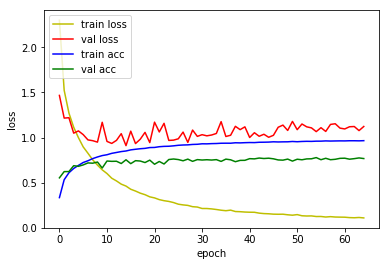

4815/4815 [==============================] - 4s 886us/sample - loss: 0.9896 - acc: 0.7171
Loss: 0.9895950038608856 Accuracy: 0.71713394

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1487 - acc: 0.3613
Epoch 00001: val_loss improved from inf to 1.32555, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_5_conv_checkpoint/001-1.3255.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 2.1487 - acc: 0.3613 - val_loss: 1.3255 - val_acc: 0.5772
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3783 - acc: 0.5680
Epoch 00002: val_loss improved from 1.32555 to 1.07061, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_5_conv_checkpoint/002-1.0706.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.3783 - acc: 0.5680 - val_loss: 1.0706 - val_acc: 0.6851
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2910 - acc: 0.9066
Epoch 00026: val_loss did not improve from 0.65965
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2910 - acc: 0.9066 - val_loss: 0.7893 - val_acc: 0.7859
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2794 - acc: 0.9106
Epoch 00027: val_loss did not improve from 0.65965
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2794 - acc: 0.9106 - val_loss: 0.7071 - val_acc: 0.8185
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2632 - acc: 0.9151
Epoch 00028: val_loss did not improve from 0.65965
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2633 - acc: 0.9150 - val_loss: 0.7456 - val_acc: 0.8029
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2658 - acc: 0.9144
Epoch 00029: val_loss did not improve from 0.65965
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1351 - acc: 0.9573
Epoch 00056: val_loss did not improve from 0.65965
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1352 - acc: 0.9573 - val_loss: 0.7495 - val_acc: 0.8253
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1267 - acc: 0.9599
Epoch 00057: val_loss did not improve from 0.65965
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1268 - acc: 0.9599 - val_loss: 0.7607 - val_acc: 0.8199
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1257 - acc: 0.9607
Epoch 00058: val_loss did not improve from 0.65965
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1257 - acc: 0.9607 - val_loss: 0.8154 - val_acc: 0.8181
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1189 - acc: 0.9621
Epoch 00059: val_loss did not improve from 0.65965
36805/36805 [===========

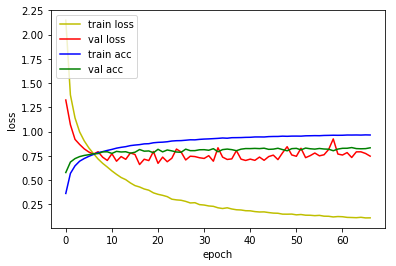

4815/4815 [==============================] - 4s 920us/sample - loss: 0.7483 - acc: 0.7832
Loss: 0.7482678103422202 Accuracy: 0.78317755

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2206 - acc: 0.3245
Epoch 00001: val_loss improved from inf to 1.34546, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_6_conv_checkpoint/001-1.3455.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 2.2204 - acc: 0.3246 - val_loss: 1.3455 - val_acc: 0.5674
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4054 - acc: 0.5573
Epoch 00002: val_loss improved from 1.34546 to 1.02997, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_6_conv_checkpoint/002-1.0300.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.4054 - acc: 0.5573 - val_loss: 1.0300 - val_acc: 0.6902
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2966 - acc: 0.9094
Epoch 00025: val_loss improved from 0.40985 to 0.40834, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_6_conv_checkpoint/025-0.4083.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2965 - acc: 0.9094 - val_loss: 0.4083 - val_acc: 0.8856
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2889 - acc: 0.9121
Epoch 00026: val_loss did not improve from 0.40834
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2889 - acc: 0.9121 - val_loss: 0.4290 - val_acc: 0.8770
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2788 - acc: 0.9149
Epoch 00027: val_loss improved from 0.40834 to 0.40188, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_6_conv_checkpoint/027-0.4019.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2788 - acc: 0.9150 - v

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1424 - acc: 0.9557
Epoch 00053: val_loss did not improve from 0.37461
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1424 - acc: 0.9557 - val_loss: 0.4275 - val_acc: 0.9005
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1409 - acc: 0.9555
Epoch 00054: val_loss did not improve from 0.37461
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1409 - acc: 0.9555 - val_loss: 0.4001 - val_acc: 0.8973
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1374 - acc: 0.9570
Epoch 00055: val_loss did not improve from 0.37461
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1374 - acc: 0.9570 - val_loss: 0.3897 - val_acc: 0.9036
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1383 - acc: 0.9557
Epoch 00056: val_loss did not improve from 0.37461
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0853 - acc: 0.9730
Epoch 00083: val_loss did not improve from 0.37461
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0854 - acc: 0.9730 - val_loss: 0.5440 - val_acc: 0.8880
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9704
Epoch 00084: val_loss did not improve from 0.37461
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0942 - acc: 0.9704 - val_loss: 0.4098 - val_acc: 0.9045
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0765 - acc: 0.9752
Epoch 00085: val_loss did not improve from 0.37461
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0768 - acc: 0.9752 - val_loss: 0.4869 - val_acc: 0.8919
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0907 - acc: 0.9709
Epoch 00086: val_loss did not improve from 0.37461
36805/36805 [===========

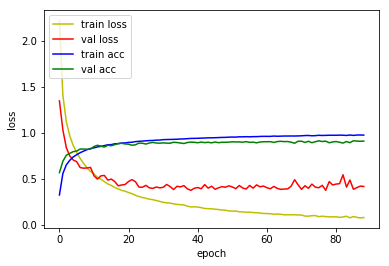

4815/4815 [==============================] - 5s 982us/sample - loss: 0.4655 - acc: 0.8719
Loss: 0.46552579213525647 Accuracy: 0.8718588

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3912 - acc: 0.2755
Epoch 00001: val_loss improved from inf to 1.46203, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_7_conv_checkpoint/001-1.4620.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 2.3912 - acc: 0.2755 - val_loss: 1.4620 - val_acc: 0.5611
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4897 - acc: 0.5234
Epoch 00002: val_loss improved from 1.46203 to 1.02697, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_7_conv_checkpoint/002-1.0270.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.4897 - acc: 0.5234 - val_loss: 1.0270 - val_acc: 0.6923
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2134 - acc: 0.9330
Epoch 00024: val_loss did not improve from 0.25789
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2134 - acc: 0.9330 - val_loss: 0.2928 - val_acc: 0.9206
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2060 - acc: 0.9351
Epoch 00025: val_loss improved from 0.25789 to 0.24819, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_7_conv_checkpoint/025-0.2482.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2063 - acc: 0.9351 - val_loss: 0.2482 - val_acc: 0.9324
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2026 - acc: 0.9366
Epoch 00026: val_loss did not improve from 0.24819
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2027 - acc: 0.9366 - val_loss: 0.2735 - val_acc: 0.9313
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0979 - acc: 0.9686
Epoch 00052: val_loss did not improve from 0.21627
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0981 - acc: 0.9686 - val_loss: 0.2200 - val_acc: 0.9436
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0888 - acc: 0.9720
Epoch 00053: val_loss did not improve from 0.21627
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0888 - acc: 0.9720 - val_loss: 0.2202 - val_acc: 0.9443
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9730
Epoch 00054: val_loss did not improve from 0.21627
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0841 - acc: 0.9730 - val_loss: 0.2450 - val_acc: 0.9418
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0839 - acc: 0.9734
Epoch 00055: val_loss did not improve from 0.21627
36805/36805 [===========

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9910
Epoch 00111: val_loss did not improve from 0.21312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0293 - acc: 0.9910 - val_loss: 0.2292 - val_acc: 0.9529
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9913
Epoch 00112: val_loss did not improve from 0.21312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0287 - acc: 0.9913 - val_loss: 0.2506 - val_acc: 0.9481
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9874
Epoch 00113: val_loss did not improve from 0.21312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0403 - acc: 0.9874 - val_loss: 0.2549 - val_acc: 0.9499
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9898
Epoch 00114: val_loss did not improve from 0.21312
36805/36805 [=======

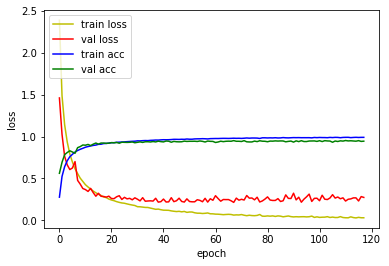

4815/4815 [==============================] - 5s 998us/sample - loss: 0.2775 - acc: 0.9259
Loss: 0.277451082336816 Accuracy: 0.9258567

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4235 - acc: 0.2815
Epoch 00001: val_loss improved from inf to 1.36629, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_8_conv_checkpoint/001-1.3663.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 2.4235 - acc: 0.2815 - val_loss: 1.3663 - val_acc: 0.5986
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4048 - acc: 0.5509
Epoch 00002: val_loss improved from 1.36629 to 0.87731, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_8_conv_checkpoint/002-0.8773.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 1.4048 - acc: 0.5509 - val_loss: 0.8773 - val_acc: 0.7417
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9846
Epoch 00052: val_loss did not improve from 0.13950
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0493 - acc: 0.9845 - val_loss: 0.1731 - val_acc: 0.9548
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9864
Epoch 00053: val_loss did not improve from 0.13950
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0445 - acc: 0.9864 - val_loss: 0.1714 - val_acc: 0.9557
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9882
Epoch 00054: val_loss did not improve from 0.13950
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0393 - acc: 0.9882 - val_loss: 0.1973 - val_acc: 0.9555
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9855
Epoch 00055: val_loss did not improve from 0.13950
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9933
Epoch 00082: val_loss did not improve from 0.13950
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0209 - acc: 0.9933 - val_loss: 0.2621 - val_acc: 0.9455
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9933
Epoch 00083: val_loss did not improve from 0.13950
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0214 - acc: 0.9933 - val_loss: 0.1937 - val_acc: 0.9604
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9933
Epoch 00084: val_loss did not improve from 0.13950
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0208 - acc: 0.9933 - val_loss: 0.2131 - val_acc: 0.9569
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9918
Epoch 00085: val_loss did not improve from 0.13950
36805/36805 [===========

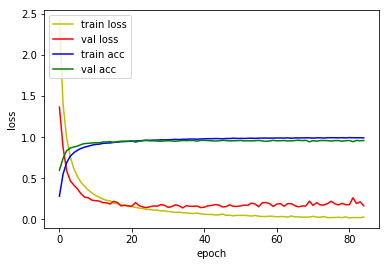

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1711 - acc: 0.9487
Loss: 0.17107631326696582 Accuracy: 0.948702

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0771 - acc: 0.3923
Epoch 00001: val_loss improved from inf to 0.85990, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_9_conv_checkpoint/001-0.8599.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 2.0771 - acc: 0.3923 - val_loss: 0.8599 - val_acc: 0.7414
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9626 - acc: 0.6977
Epoch 00002: val_loss improved from 0.85990 to 0.47734, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_BN_9_conv_checkpoint/002-0.4773.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.9625 - acc: 0.6977 - val_loss: 0.4773 - val_acc: 0.8637
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0665 - acc: 0.9798
Epoch 00025: val_loss did not improve from 0.12344
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.0666 - acc: 0.9797 - val_loss: 0.1653 - val_acc: 0.9506
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0769 - acc: 0.9756
Epoch 00026: val_loss did not improve from 0.12344
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.0770 - acc: 0.9756 - val_loss: 0.1356 - val_acc: 0.9595
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9805
Epoch 00027: val_loss did not improve from 0.12344
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.0620 - acc: 0.9805 - val_loss: 0.1415 - val_acc: 0.9613
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9817
Epoch 00028: val_loss did not improve from 0.12344
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9938
Epoch 00084: val_loss did not improve from 0.11990
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0209 - acc: 0.9938 - val_loss: 0.1595 - val_acc: 0.9660
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9950
Epoch 00085: val_loss did not improve from 0.11990
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0163 - acc: 0.9950 - val_loss: 0.1364 - val_acc: 0.9697
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9985
Epoch 00086: val_loss did not improve from 0.11990
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0060 - acc: 0.9985 - val_loss: 0.1498 - val_acc: 0.9653
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9974
Epoch 00087: val_loss did not improve from 0.11990
36805/36805 [===========

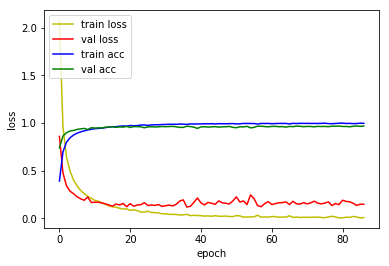

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2010 - acc: 0.9464
Loss: 0.20103070230681647 Accuracy: 0.94641745



In [10]:
base = '1D_CNN_custom_he-uniform_DO_BN'

for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_he-uniform_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_he-uniform_DO_BN_3_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 64)         256  

4815/4815 [==============================] - 4s 839us/sample - loss: 0.7483 - acc: 0.7832
Loss: 0.7482678103422202 Accuracy: 0.78317755

1D_CNN_custom_he-uniform_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_57 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_57 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_58 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_58 (Activation) 

4815/4815 [==============================] - 4s 922us/sample - loss: 0.2775 - acc: 0.9259
Loss: 0.277451082336816 Accuracy: 0.9258567

1D_CNN_custom_he-uniform_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_70 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_70 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_71 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_71 (Activation)   

4815/4815 [==============================] - 5s 957us/sample - loss: 0.2010 - acc: 0.9464
Loss: 0.20103070230681647 Accuracy: 0.94641745


In [9]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

with open(path.join(log_dir, base)+'_last', 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_he-uniform_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (N

4815/4815 [==============================] - 5s 995us/sample - loss: 0.8583 - acc: 0.8019
Loss: 0.8583122308380507 Accuracy: 0.80186915

1D_CNN_custom_he-uniform_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_57 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_57 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_58 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_58 (Activation) 

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3382 - acc: 0.9252
Loss: 0.33818601191141534 Accuracy: 0.92523366

1D_CNN_custom_he-uniform_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_70 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_70 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_71 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_71 (Activation)  

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2094 - acc: 0.9529
Loss: 0.2093510176634067 Accuracy: 0.95285565
